# FCN

In [1]:
# please upload data directory to Google drive
# use Google Drive to load data
from google.colab import drive, files
import zipfile

drive.mount('/content/drive')
filename = 'requirements.txt'
uploaded = files.upload()

Mounted at /content/drive


Saving requirements.txt to requirements.txt


In [2]:
!pip install -r "./requirements.txt"
!pip install torchinfo
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.9/171.9 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.4/346.4 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.0/812.0 kB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [3]:
from torch.nn import (Module, Sequential, Conv2d, BatchNorm2d, ReLU, MaxPool2d,
                      Linear, AdaptiveAvgPool2d, BatchNorm1d, Sigmoid, Dropout)
import torch
from sklearn.model_selection import train_test_split
import os
import librosa
import numpy as np
from torchinfo import summary
from torch import nn
from torch.optim import Adam
from torcheval.metrics import MulticlassAUROC, MulticlassF1Score
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Add Methods

In [4]:
# Util
def create_dataloader(x, y, batch_size=64, cuda=False):
    if cuda:
        x = torch.tensor(x, dtype=torch.float).cuda()
        y = torch.tensor(y, dtype=torch.long).cuda()
    else:
        x = torch.tensor(x, dtype=torch.float)
        y = torch.tensor(y, dtype=torch.long)
    data = TensorDataset(x, y)
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    return dataloader


def k_fold_cross_validation(x, y, k):
    fold_size = x.shape[0] // k
    xs_train = []
    ys_train = []
    xs_valid = []
    ys_valid = []
    for i in range(k - 1):
        xs_valid.append(x[fold_size * i:fold_size * (i + 1)])
        ys_valid.append(y[fold_size * i:fold_size * (i + 1)])
        xs_train.append(np.concatenate([x[:fold_size * i], x[fold_size * (i + 1):]], axis=0))
        ys_train.append(np.concatenate([y[:fold_size * i], y[fold_size * (i + 1):]], axis=0))
    xs_valid.append(x[fold_size * (k - 1):])
    ys_valid.append(y[fold_size * (k - 1):])
    xs_train.append(x[:fold_size * (k - 1)])
    ys_train.append(y[:fold_size * (k - 1)])
    return xs_train, ys_train, xs_valid, ys_valid

def train(model, loss_function, opt, dataloaders_train, dataloaders_valid, k, epoch=10):
    epochs_loss = []
    epochs_accuracy = []
    for i in range(epoch):
        print("-------epoch  {} -------".format(i + 1))
        epoch_loss = 0
        epoch_accuracy = 0

        for j in range(k):
            print(f'fold {j + 1}:')

            # train
            loss_train = 0
            accuracy_train = 0
            train_size = 0
            for batch_idx, (data, target) in enumerate(dataloaders_train[j]):
                data = data.cuda()
                target = target.cuda()
                model.train()
                output = model(data)
                loss = loss_function(output, target)
                opt.zero_grad()
                loss.backward()
                opt.step()
                data_size = len(data)
                loss_train += loss.item() * data_size
                accuracy_train += (output.argmax(1) == target).sum()
                train_size += data_size
            print("train set loss: {}".format(loss_train / train_size))
            print("train set accuracy: {}".format(accuracy_train / train_size))

            # valid
            loss_valid = 0
            accuracy_valid = 0
            valid_size = 0
            for batch_idx, (data, target) in enumerate(dataloaders_valid[j]):
                data = data.cuda()
                target = target.cuda()
                model.eval()
                with torch.no_grad():
                    output = model(data)
                    loss = loss_function(output, target)
                    data_size = len(data)
                    loss_valid += loss.item() * data_size
                    accuracy_valid += (output.argmax(1) == target).sum()
                    valid_size += data_size
            print("valid set loss: {}".format(loss_valid / valid_size))
            print("valid set accuracy: {}".format(accuracy_valid / valid_size))
            epoch_loss += loss_valid / valid_size
            epoch_accuracy += accuracy_valid / valid_size
        epoch_loss = round(epoch_loss / k, 3)
        epoch_accuracy = round(float(epoch_accuracy) / k, 3)
        print(f"epoch loss: {epoch_loss}")
        print(f"epoch accuracy: {epoch_accuracy}")
        epochs_loss.append(epoch_loss)
        epochs_accuracy.append(epoch_accuracy)
    return {"loss": epochs_loss, "accuracy": epochs_accuracy}


def test(model, loss_function, dataloader_test):
    loss_test = 0
    accuracy_test = 0
    AUC_test = 0
    f1_score_test = 0
    test_size = 0
    for batch_idx, (data, target) in enumerate(dataloader_test):
        data = data.cuda()
        target = target.cuda()
        model.eval()
        with torch.no_grad():
            output = model(data)
            loss = loss_function(output, target)
            loss_test += loss.item() * len(data)
            accuracy_test += (output.argmax(1) == target).sum()
            test_size += len(data)
            auc = MulticlassAUROC(num_classes=10)
            auc.update(output, target)
            AUC_test += auc.compute() * len(data)
            auc.reset()
            f1 = MulticlassF1Score(num_classes=10)
            f1.update(output, target)
            f1_score_test += f1.compute() * len(data)
            f1.reset()
    loss = round(loss_test / test_size, 3)
    accuracy = round(float(accuracy_test) / test_size,3)
    AUC = round(float(AUC_test) / test_size, 3)
    f1 = round(float(f1_score_test) / test_size,3)
    print(f"test set loss: {loss}")
    print(f"test set accuracy: {accuracy}")
    print(f"test set AUC: {AUC}")
    print(f"test set f1-score: {f1}")
    return loss, accuracy, AUC, f1

# Read Data

In [5]:
root = '/content/drive/MyDrive/why/genres_original' # Change according path storing data
genres = os.listdir(root)
x = []
y = []
length = []
sr = 16*1000
for genre in genres:
    genre_root = os.path.join(root, genre)
    audios = os.listdir(genre_root)
    for audio in audios:
        audio_path = os.path.join(genre_root, audio)
        signal, sr = librosa.load(audio_path, sr=sr)
        x.append(signal)
        length.append(len(signal))
        y.append(genres.index(genre))
min_length = min(length)
print("Finsh reading data")

Finsh reading data


# Segment and Normalise

In [6]:
top_db = 80
for i in range(len(x)):
    signal = x[i][:min_length]
    mel_spect = librosa.feature.melspectrogram(y=signal,sr=sr,n_fft=1024) # convert signals to mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max, top_db=top_db) # log compression
    x[i] = mel_spect/-top_db # normalisation
print("finish conversion and compression")

finish conversion and compression


# Split Data

In [7]:
x = np.asarray(x)
# x = x.transpose((0,2,1))
x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
y = np.asarray(y)
print(x.shape)

(1000, 1, 128, 936)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    stratify=y,shuffle=True)
# k-fold cross validation
k = 5
xs_train, ys_train, xs_valid, ys_valid = k_fold_cross_validation(x_train,y_train,k)
print("finish splitting data")

finish splitting data


# Create Dataloaders

In [9]:
batch_size = 32
dataloaders_train = []
dataloaders_valid = []
for i in range(k):
    dataloaders_train.append(create_dataloader(xs_train[i], ys_train[i], batch_size=batch_size))
    dataloaders_valid.append(create_dataloader(xs_valid[i], ys_valid[i], batch_size=batch_size))
dataloader_test = create_dataloader(x_test, y_test, batch_size=batch_size)
print("finish creating dataloaders")

finish creating dataloaders


# FCN Model

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_filters, out_filters, stride=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(out_filters)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class FCN7(nn.Module):
    def __init__(self, class_num, pre_filter_size=7, in_channels=3):
        super(FCN7, self).__init__()

        self.conv1 = ConvBlock(1, 128)
        self.mp1 = nn.MaxPool2d((2, 4))
        # self.mp1 = nn.MaxPool2d((2, 2))


        self.conv2 = ConvBlock(128, 256)
        self.mp2 = nn.MaxPool2d((2, 4))
        # self.mp2 = nn.MaxPool2d((2, 2))

        self.conv3 = ConvBlock(256, 512)
        self.mp3 = nn.MaxPool2d((2, 4))
        # self.mp3 = nn.MaxPool2d((2, 2))

        self.conv4 = ConvBlock(512, 1024)
        self.mp4 = nn.MaxPool2d((3, 4))
        # self.mp4 = nn.MaxPool2d((2, 2))

        self.conv5 = ConvBlock(1024, 2048)
        self.mp5 = nn.MaxPool2d((4, 2))
        # self.mp5 = nn.MaxPool2d((2, 2))


        self.conv6 = nn.Conv2d(2048, 1024, kernel_size=1) # 1x1 convolutions
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1) # additional 1x1 convolution as per FCN-7


        self.avg_pool = AdaptiveAvgPool2d((1,1))

        # Fully connected layer with batch normalization and sigmoid activation
        self.fc = nn.Sequential(
            nn.Linear(1024, class_num),
            nn.BatchNorm1d(class_num),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.mp1(self.conv1(x))
        # print("After layer 1 & mp1:", x.shape)
        x = self.mp2(self.conv2(x))
        # print("After layer 2 & mp2:", x.shape)
        x = self.mp3(self.conv3(x))
        # print("After layer 3 & mp3:", x.shape)
        x = self.mp4(self.conv4(x))
        # print("After layer 4 & mp4:", x.shape)
        x = self.mp5(self.conv5(x))
        # print("After layer 5 & mp5:", x.shape)

        x = self.conv6(x)
        x = self.conv7(x)
        x = self.avg_pool(x)

        x = x.view(x.size(0), -1)  # Flatten the output
        # print("Shape before FC layer:", x.shape)

        # Apply the fully connected layer
        x = self.fc(x)
        return x

# Model Construction

In [11]:
class_num = 10
model = FCN7(class_num=class_num).cuda()
loss_function = nn.CrossEntropyLoss()
opt = Adam(model.parameters(), lr=0.001)
summary(model, input_size=[batch_size,1,x.shape[2],x.shape[3]])

Layer (type:depth-idx)                   Output Shape              Param #
FCN7                                     [32, 10]                  --
├─ConvBlock: 1-1                         [32, 128, 128, 936]       --
│    └─Conv2d: 2-1                       [32, 128, 128, 936]       1,280
│    └─BatchNorm2d: 2-2                  [32, 128, 128, 936]       256
│    └─ReLU: 2-3                         [32, 128, 128, 936]       --
├─MaxPool2d: 1-2                         [32, 128, 64, 234]        --
├─ConvBlock: 1-3                         [32, 256, 64, 234]        --
│    └─Conv2d: 2-4                       [32, 256, 64, 234]        295,168
│    └─BatchNorm2d: 2-5                  [32, 256, 64, 234]        512
│    └─ReLU: 2-6                         [32, 256, 64, 234]        --
├─MaxPool2d: 1-4                         [32, 256, 32, 58]         --
├─ConvBlock: 1-5                         [32, 512, 32, 58]         --
│    └─Conv2d: 2-7                       [32, 512, 32, 58]         1,180,16

# Train

In [12]:
epoch = 10
history = train(model,loss_function,opt,dataloaders_train,dataloaders_valid,k,epoch=epoch)
print("finish training")

-------epoch  1 -------
fold 1:
train set loss: 2.1564594149589538
train set accuracy: 0.2828125059604645
valid set loss: 2.284774732589722
valid set accuracy: 0.11250000447034836
fold 2:
train set loss: 2.0775129556655885
train set accuracy: 0.5
valid set loss: 2.3304131507873533
valid set accuracy: 0.13125000894069672
fold 3:
train set loss: 2.0510460674762725
train set accuracy: 0.5406250357627869
valid set loss: 2.1072030544281004
valid set accuracy: 0.33125001192092896
fold 4:
train set loss: 2.006807655096054
train set accuracy: 0.6703125238418579
valid set loss: 2.0809765338897703
valid set accuracy: 0.375
fold 5:
train set loss: 1.996516728401184
train set accuracy: 0.6734375357627869
valid set loss: 2.018948268890381
valid set accuracy: 0.35625001788139343
epoch loss: 2.164
epoch accuracy: 0.261
-------epoch  2 -------
fold 1:
train set loss: 1.9667200863361358
train set accuracy: 0.7265625
valid set loss: 1.9957401037216187
valid set accuracy: 0.5250000357627869
fold 2:
train

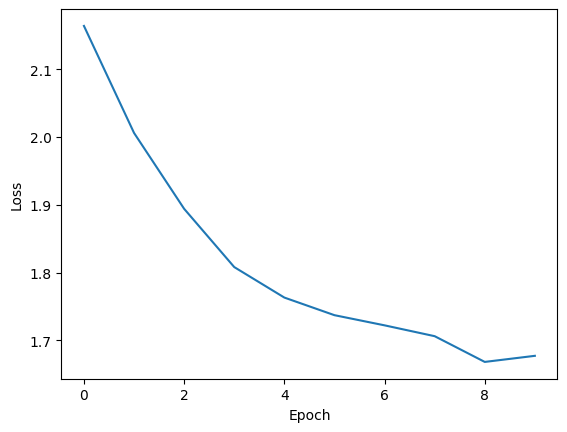

In [13]:
plt.plot(range(epoch),history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

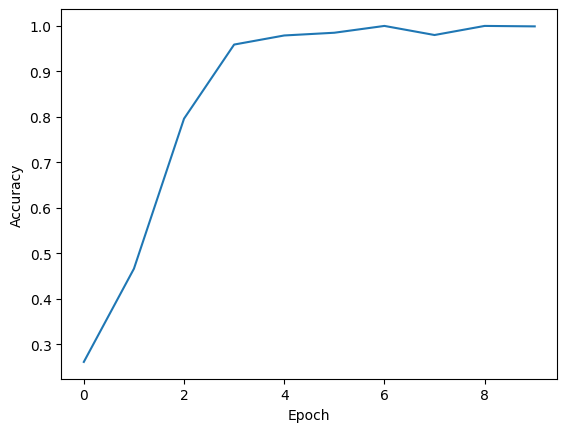

In [14]:
plt.plot(range(epoch), history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Test

In [15]:
loss, acc, AUC, f1 = test(model,loss_function,dataloader_test)

test set loss: 1.874
test set accuracy: 0.725
test set AUC: 0.945
test set f1-score: 0.725
